In [1]:
# Load dictionary
# Need model definition, right?
import torch.nn as nn

# from src.autoencoder import UntiedSAE
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# dictionary_path = "models/pythia-70m-deduped_gpt_neox.layers.3_Ratio-4_l1-0.003_lr-0.001_2024_02_27_17_47_39_model.pt"
dictionary_path = "models/pythia-70m-deduped_gpt_neox.layers.3_Ratio-4_l1-0.003_lr-0.001_2024_02_27_19_24_10_model.pt"
layer = 3
activation_name = f"gpt_neox.layers.{layer}"
sae = torch.load(dictionary_path).to(device)

/root/logan/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [68]:
# Load data
from src.utils import get_dataloader
from transformers import AutoModelForCausalLM, AutoTokenizer
model_name = "EleutherAI/pythia-70m-deduped"
dataset_name = "Elriggs/openwebtext-100k"
# dataset_name = "jbrinkma/pile-500k"
batch_size = 16
context_length = 256
# model and dataset
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
train_loader, test_loader = get_dataloader(dataset_name, tokenizer, batch_size, context_length)
# Freeze the model & dictionary
model.eval()
model.requires_grad_(False)
sae.requires_grad_(False)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


UntiedSAE()

In [3]:
from baukit import Trace

def dict_ablation_fn_k(representation, k=0):
    if(isinstance(representation, tuple)):
        second_value = representation[1]
        internal_activation = representation[0]
    else:
        internal_activation = representation

    features = sae.encode(internal_activation)
    # get the k-lowest features per datapoint

    # features[:,:] = 0
    reconstruction = sae.decode(features)

    if(isinstance(representation, tuple)):
        return_value = (reconstruction, second_value)
    else:
        return_value = reconstruction

    return return_value
       
def compute_loss(inputs_ids, logits):
    return torch.nn.CrossEntropyLoss()(
        logits[:,:-1,:].reshape(-1, logits.shape[-1]),
        inputs_ids[:,1:].reshape(-1)
    ).item()

In [7]:
sae.W_d.shape, sae.W_e.shape, input_ids.shape

(torch.Size([512, 2048]), torch.Size([2048, 512]), torch.Size([16, 256]))

In [88]:
from baukit import Trace
from einops import rearrange

# import partial
from functools import partial
# Load in N batches
N = 100
k = 0
d_model, n_features = sae.W_d.shape
tokens_per_batch = batch_size * context_length
all_features = torch.zeros(tokens_per_batch*N, n_features)
with torch.no_grad():
    for ind_batch, batch in enumerate(train_loader):
    # for ind_batch, batch in enumerate(test_loader):
        if ind_batch >= N:
            break
        input_ids = batch["input_ids"].to(device)
        hook_function = partial(dict_ablation_fn_k, k=k)
        with Trace(model, activation_name, edit_output = dict_ablation_fn_k) as ret:
            logits = model(input_ids).logits
            representation = ret.output
            if(isinstance(representation, tuple)):
                representation = representation[0]
            activation = rearrange(representation, "b seq d_model -> (b seq) d_model")
            features = sae.encode(activation)
            all_features[ind_batch*tokens_per_batch:(ind_batch+1)*tokens_per_batch] = features
        outputs = model(input_ids)

In [ ]:
all_features

In [41]:
features.shape, all_features.shape

(torch.Size([4096, 2048]), torch.Size([81920, 2048]))

In [30]:
representation
activation = rearrange(representation, "b seq d_model -> (b seq) d_model")
# activation = rearrange(representation[:, 1:, :], "b seq d_model -> (b seq) d_model")

# run through SAE
features = sae.encode(activation)
# get the k-lowest features per datapoint

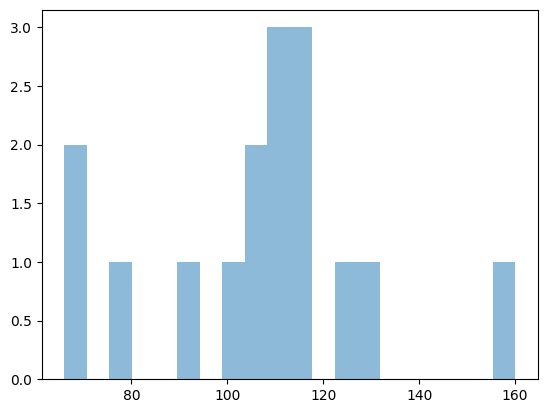

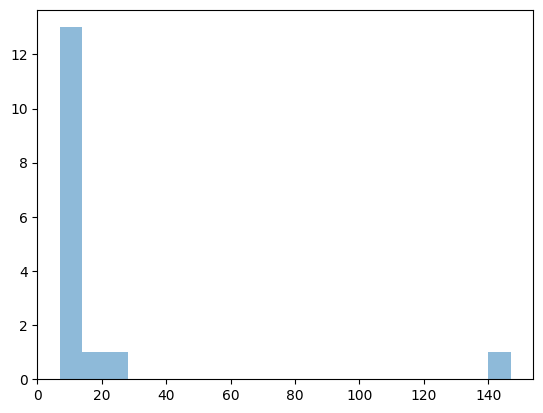

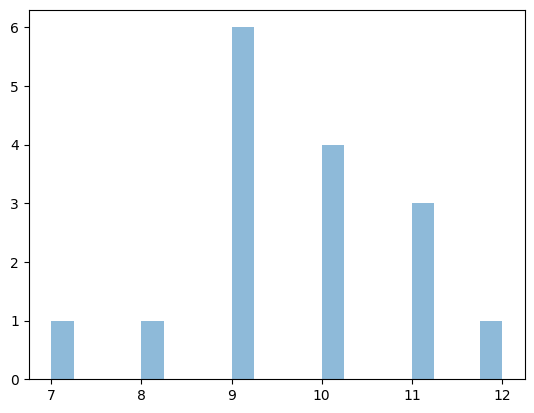

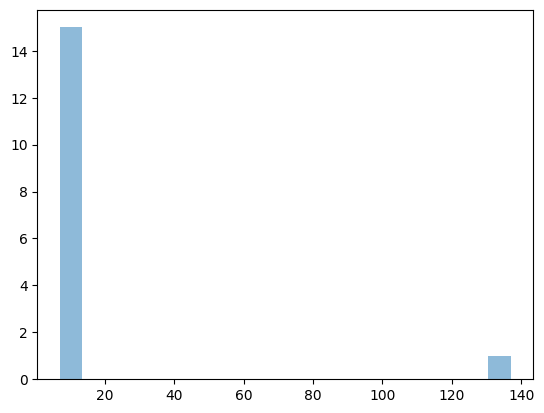

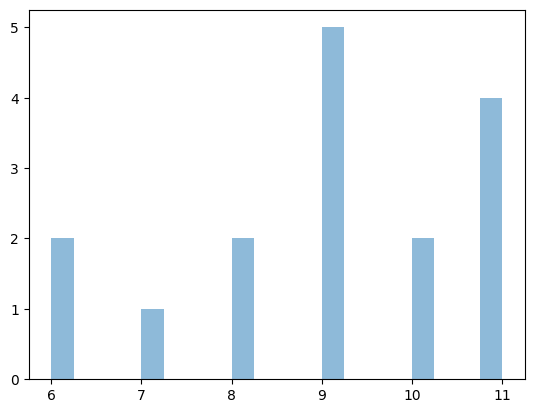

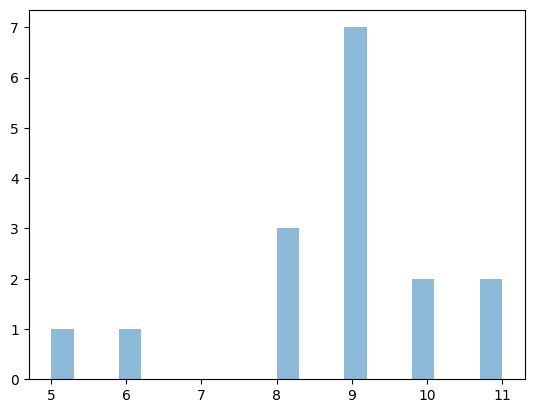

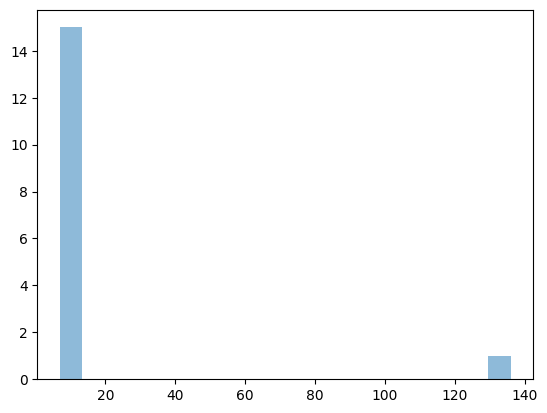

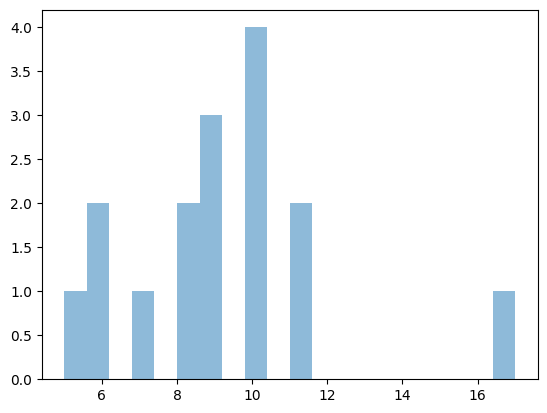

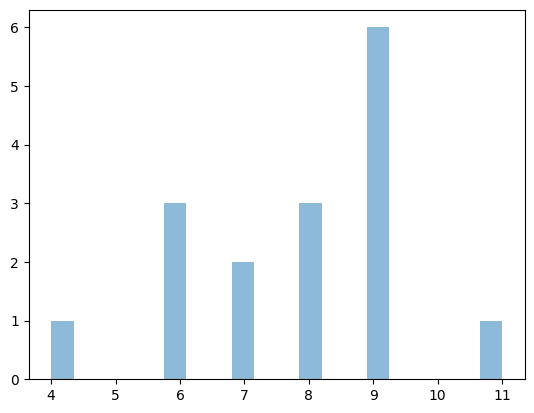

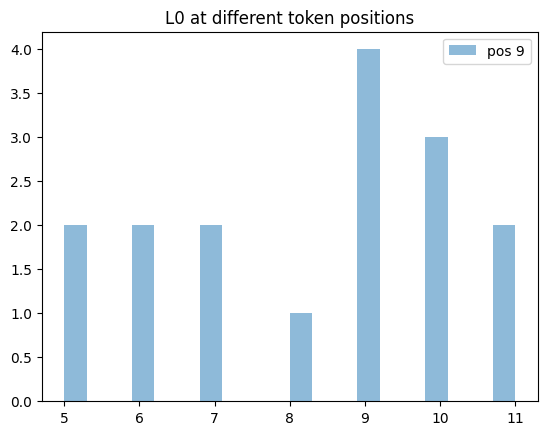

In [92]:
num_pos = 10
scale = 1
features_by_pos = [sae.encode(representation[:, (i*scale):(i*scale)+1, :].squeeze()) for i in range(num_pos)]
# Plot each as a hist in a new plot
import matplotlib.pyplot as plt
import numpy as np
for i in range(num_pos):
    # plot a new histogram
    plt.figure()
    zero_feature = features_by_pos[i].count_nonzero(-1)
    plt.hist(zero_feature.cpu().numpy(), bins=20, alpha=0.5, label=f"pos {i*scale}")
    # print(f"topk features num {zero_feature.topk(10)}")
plt.title("L0 at different token positions")
plt.legend()
plt.show()

In [81]:
zero_feature, features_by_pos[i].shape

(tensor([ 9,  9,  9,  7,  8, 10,  8,  8,  8,  9,  8,  9,  9, 10,  8, 10],
        device='cuda:0'),
 torch.Size([16, 2048]))

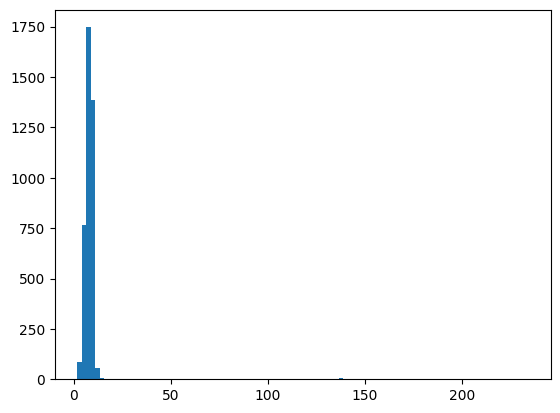

In [70]:
# get the k-lowest features per datapoint
k = 1
# shape is (batch, features)
d1 = features.count_nonzero(-1).cpu().numpy()
d1.sort()
# plot d1 as sorted line graph
import matplotlib.pyplot as plt
plt.hist(d1, bins=100)
plt.show()

In [71]:
d1[-30:]

array([106, 107, 111, 114, 115, 116, 117, 117, 120, 122, 124, 127, 127,
       130, 131, 132, 134, 134, 135, 136, 136, 137, 137, 137, 137, 138,
       140, 141, 204, 234])

In [57]:
d1.sort(), d1.sorted()

AttributeError: 'numpy.ndarray' object has no attribute 'sorted'

In [61]:
torch.norm(all_features, 0, dim=-1).median()

tensor(8.)

In [ ]:
with Trace(model, activation_name, edit_output=dict_ablation_fn) as ret:
    outputs = model(input_ids)
    logits_dict_reconstruction = outputs[0]